# **Mode collapse**

In [1]:
%%capture
import sys
!pip install tensorflow-addons
!pip install yfinance
!git clone https://github.com/ICascha/QuantGANs-replication.git
sys.path.append('/content/QuantGANs-replication/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import pandas_datareader as pdr
import yfinance as yf
yf.pdr_override()

from backend.preprocessing import rolling_window
from backend.clustering import *
from google.colab import files

In [3]:
paths = np.array(pickle.load(open( "/content/QuantGANs-replication/trained_models/paths.pickle", "rb" ))).squeeze()

In [4]:
df = pdr.get_data_yahoo("^GSPC", start="2009-1-1", end="2019-12-31")['Adj Close']
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)

In [5]:
real_returns = log_returns
synth_returns = np.log(paths[:, 1:]/paths[:, :-1]).T

In [6]:
real_samples, synth_samples, real_bins, synth_bins, total_freq, kmeans = clustering(real_returns, synth_returns, 16, 30)

# Distribution of clusters

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

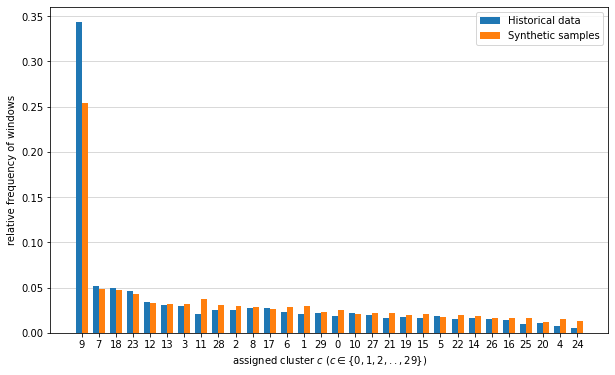

In [7]:
# sort labels by average of frequences
labels = np.argsort(-1*np.sum(total_freq, axis=1))
x = np.arange(len(labels))
y = total_freq[labels]

fig, ax = plt.subplots(figsize=(10,6))

width = 0.35

ax.bar(x - width/2, y[:,0], width)
ax.bar(x + width/2, y[:,1], width)
ax.set_ylabel('relative frequency of windows')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.grid(axis='y', which='major', alpha=.6)
ax.set_axisbelow(True);
ax.legend(['Historical data', 'Synthetic samples'])
ax.set_xlabel('assigned cluster $c$ ($c \in \{0, 1, 2, .., 29\}$)')


plt.savefig('clust_bar.png', dpi=300)
files.download("clust_bar.png") ;

# Experiments

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

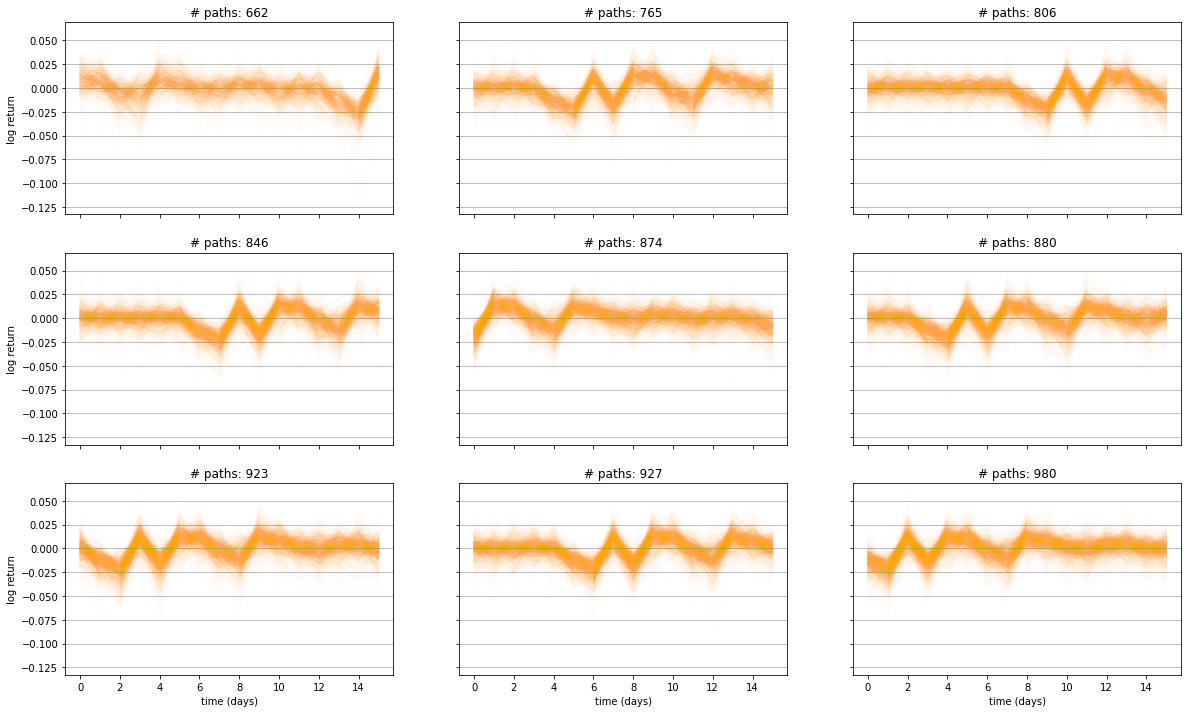

In [8]:
small_bins = np.argsort(total_freq[:, 1])[:9]
fig, ax = plot_clustering(synth_samples, synth_bins, 0.01, small_bins, (20, 12))

plt.savefig('clust_16_small.png', dpi=300)
files.download("clust_16_small.png") ;

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

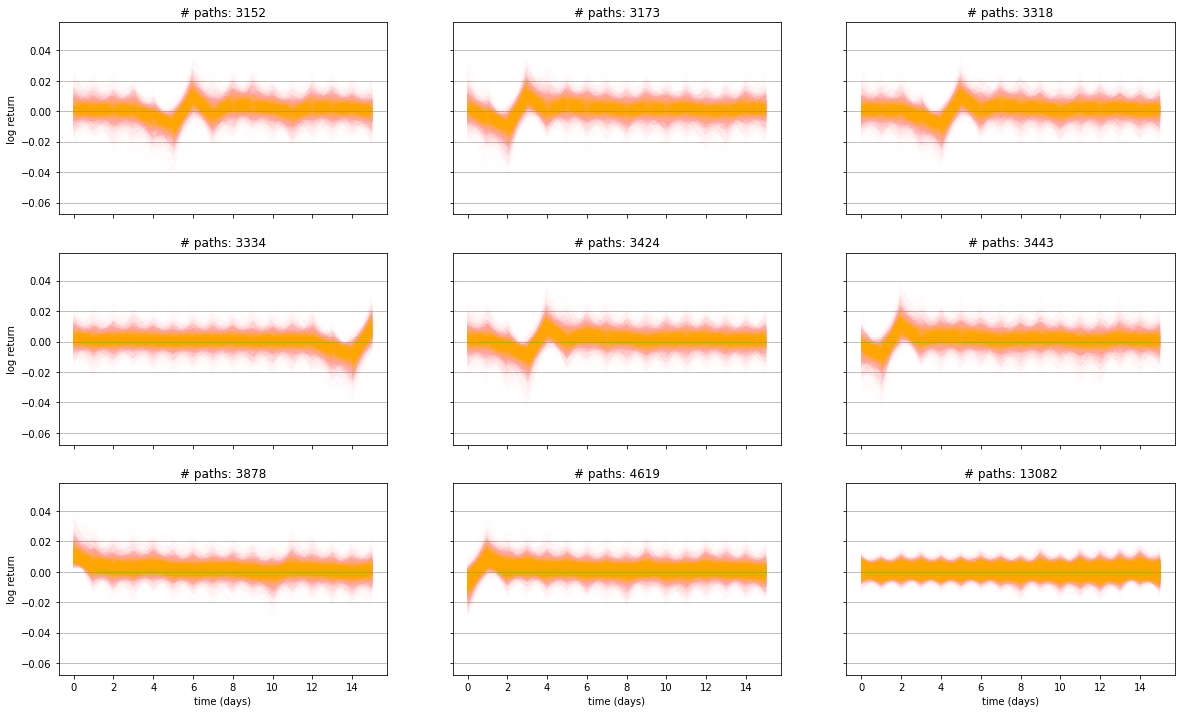

In [9]:
big_bins = np.argsort(total_freq[:, 1])[-9:]
fig, ax = plot_clustering(synth_samples, synth_bins, 0.003, big_bins, (20, 12))

plt.savefig('clust_16_big.png', dpi=300)
files.download("clust_16_big.png") ;

In [10]:
real_samples, synth_samples, real_bins, synth_bins, total_freq, kmeans = clustering(real_returns, synth_returns, 127, 30)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

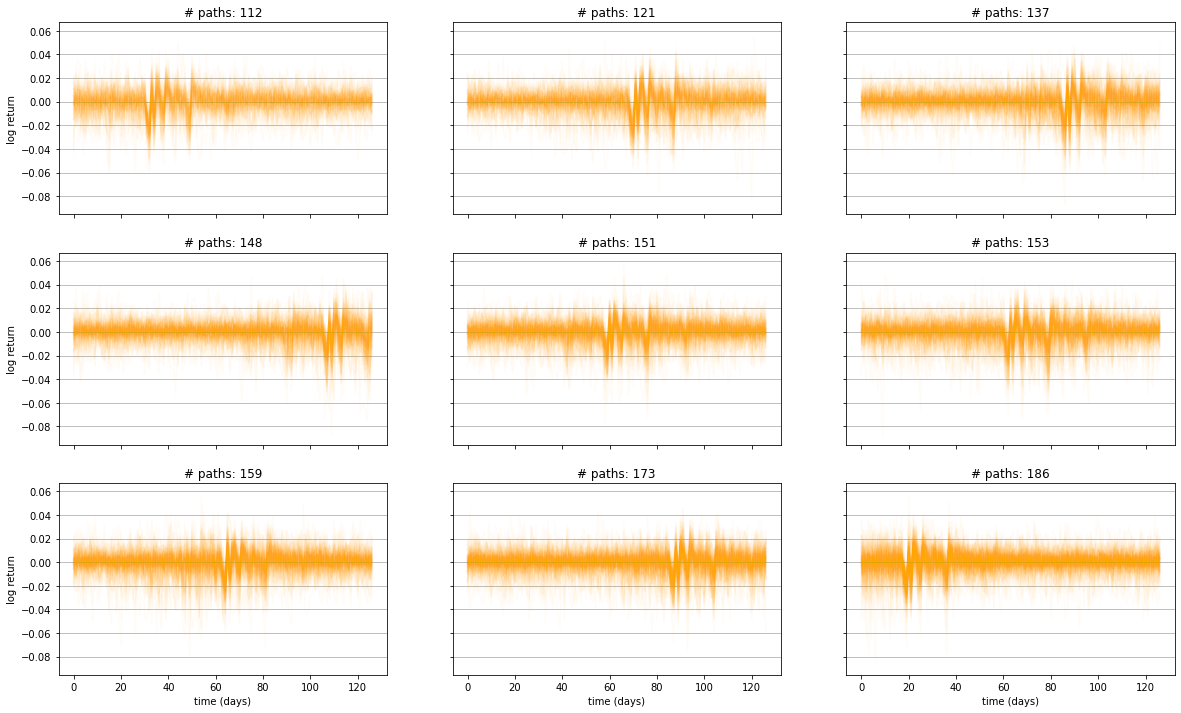

In [11]:
small_bins = np.argsort(total_freq[:, 1])[:9]
fig, ax = plot_clustering(synth_samples, synth_bins, 0.03, small_bins, (20, 12))

plt.savefig('clust_127_small.png', dpi=300)
files.download("clust_127_small.png") ;

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

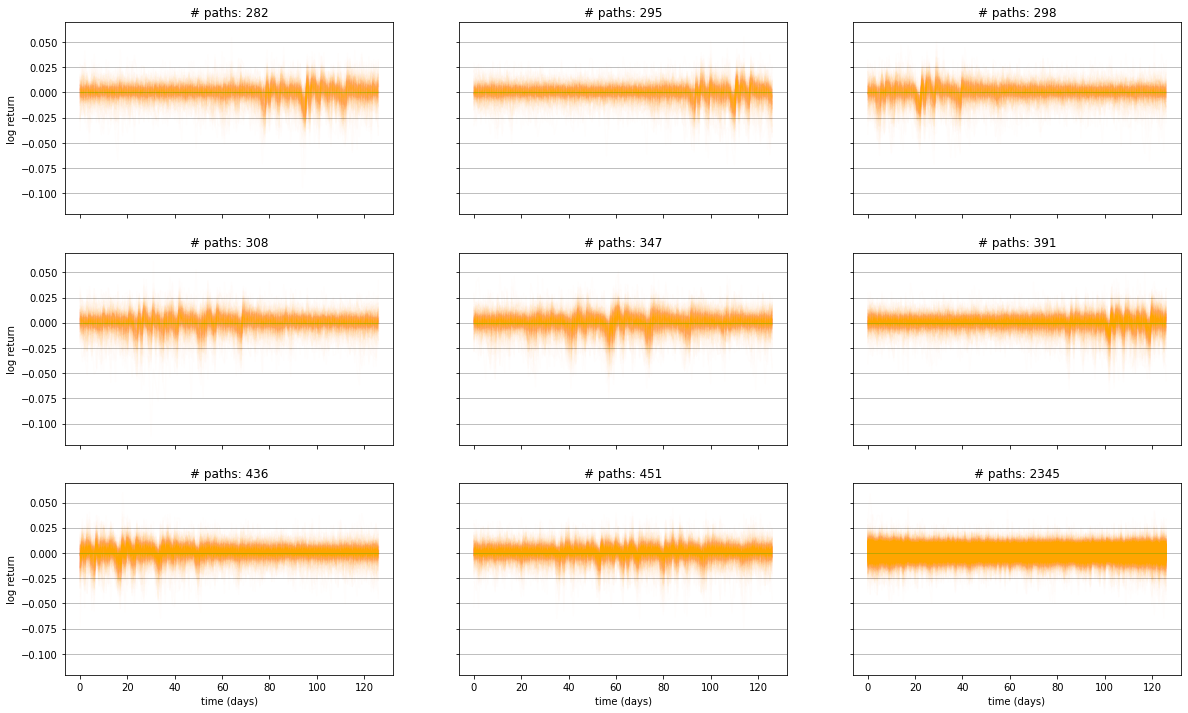

In [12]:
big_bins = np.argsort(total_freq[:, 1])[-9:]
fig, ax = plot_clustering(synth_samples, synth_bins, 0.01, big_bins, (20, 12))

plt.savefig('clust_127_big.png', dpi=300)
files.download("clust_127_big.png") ;

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

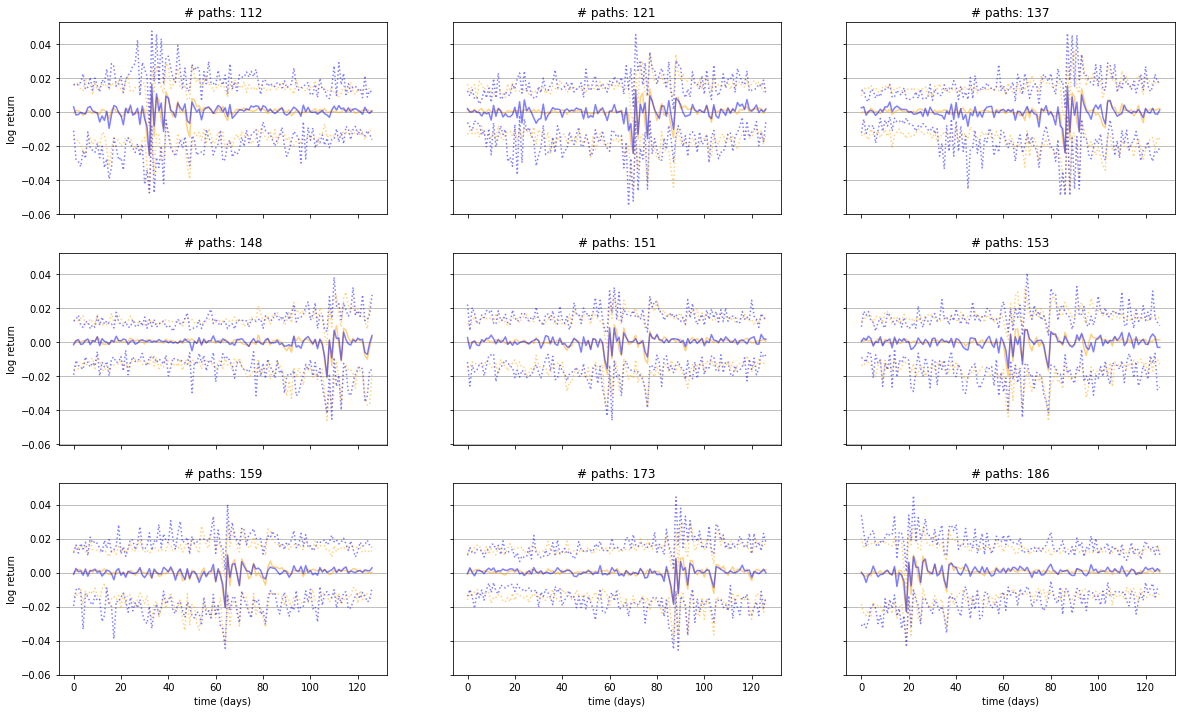

In [13]:
fig, ax = plt.subplots(figsize=(20,12), nrows=3, ncols=3, squeeze=False, sharex=True, sharey=True)

i = 0
j = 0
for bin in small_bins:
    ax[i, j].plot(synth_samples[synth_bins == bin].mean(axis=0), color='orange', alpha=0.5);
    ax[i, j].plot(np.moveaxis(np.quantile(synth_samples[synth_bins == bin], [0.05, 0.95], axis=0), 0, -1), color='orange', linestyle='dotted', alpha=.5)
    ax[i, j].set_title('# paths: {}'.format(int((synth_bins == bin).sum())))
    ax[i, j].grid(axis='y', which='major')

    if (real_bins == bin).sum() > 0:
        ax[i, j].plot(real_samples[real_bins == bin].mean(axis=0), color='blue', alpha=0.5)
        ax[i, j].plot(np.moveaxis(np.quantile(real_samples[real_bins == bin], [0.05, 0.95], axis=0), 0, -1), color='blue', linestyle='dotted', alpha=.5)
    j += 1
    j = j % 3
    if j == 0:
        i += 1
        
plt.setp(ax[-1, :], xlabel='time (days)')
plt.setp(ax[:, 0], ylabel='log return')

plt.savefig('clust_127_real.png', dpi=300)
files.download("clust_127_real.png") ;

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

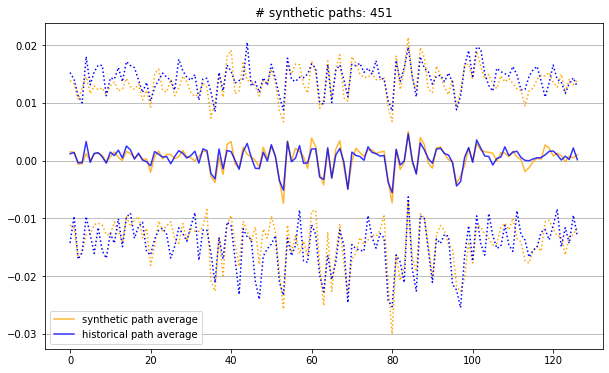

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

bin=7

ax.plot(synth_samples[synth_bins == bin].mean(axis=0), color='orange', alpha=0.8, label='synthetic path average');
ax.plot(np.moveaxis(np.quantile(synth_samples[synth_bins == bin], [0.05, 0.95], axis=0), 0, -1), color='orange', linestyle='dotted')
ax.set_title('# synthetic paths: {}'.format(int((synth_bins == bin).sum())))
ax.grid(axis='y', which='major')

ax.plot(real_samples[real_bins == bin].mean(axis=0), color='blue', alpha=0.8, label='historical path average')
ax.plot(np.moveaxis(np.quantile(real_samples[real_bins == bin], [0.05, 0.95], axis=0), 0, -1), color='blue', linestyle='dotted')
    

ax.legend();
plt.savefig('clust_127_bin.png', dpi=300)
files.download("clust_127_bin.png") ;